In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import array
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate
import re
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/categorizer_cleaned.csv")
df

,Unnamed: 0,cleaned,hate_speech,cyberbullying
0,0,dalits lowlives,1,0
1,1,gay people burden society,1,0
2,2,arabs welcome,1,0
3,3,say actually eliminate heebs wish naturally be...,1,0
4,4,bananas black people,1,0
...,...,...,...,...
101703,101703,vandaliser sajidfairooz israeliregime would ra...,1,0
101704,101704,toallahwereturn one christ terror group longer...,1,0
101705,101705,dankmtl peacenothate asshole israelis defend,1,0
101706,101706,since islam believe people leave religion murd...,1,0


In [3]:
# removing the unnamed extra index column that was formed during the construction of the dataset
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

In [4]:
df

,cleaned,hate_speech,cyberbullying
0,dalits lowlives,1,0
1,gay people burden society,1,0
2,arabs welcome,1,0
3,say actually eliminate heebs wish naturally be...,1,0
4,bananas black people,1,0
...,...,...,...
101703,vandaliser sajidfairooz israeliregime would ra...,1,0
101704,toallahwereturn one christ terror group longer...,1,0
101705,dankmtl peacenothate asshole israelis defend,1,0
101706,since islam believe people leave religion murd...,1,0


In [5]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sen))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [6]:
labels = df[["hate_speech", "cyberbullying"]]
X = []
sentences = list(df["cleaned"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = labels.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

We need to convert text inputs into embedded vectors.

In [8]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [9]:
# We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [10]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(2, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [11]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          5222300   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 5,339,806
Trainable params: 117,506
Non-trainable params: 5,222,300
_________________________________________________________________
None


In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True, dpi=1920)

In [15]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
509/509 [==============================] - 123s 240ms/step - loss: 0.6910 - acc: 0.5482 - val_loss: 0.6851 - val_acc: 0.5555
Epoch 2/10
509/509 [==============================] - 132s 259ms/step - loss: 0.6827 - acc: 0.5589 - val_loss: 0.6841 - val_acc: 0.5579
Epoch 3/10
509/509 [==============================] - 136s 267ms/step - loss: 0.5269 - acc: 0.7524 - val_loss: 0.4478 - val_acc: 0.8000
Epoch 4/10
509/509 [==============================] - 132s 258ms/step - loss: 0.4170 - acc: 0.8132 - val_loss: 0.4001 - val_acc: 0.8217
Epoch 5/10
509/509 [==============================] - 134s 263ms/step - loss: 0.3851 - acc: 0.8277 - val_loss: 0.3818 - val_acc: 0.8300
Epoch 6/10
509/509 [==============================] - 137s 269ms/step - loss: 0.3641 - acc: 0.8360 - val_loss: 0.3779 - val_acc: 0.8335
Epoch 7/10
509/509 [==============================] - 140s 275ms/step - loss: 0.3494 - acc: 0.8432 - val_loss: 0.3659 - val_acc: 0.8337
Epoch 8/10
509/509 [============================

In [16]:
category = ['hate_speech','cyberbullying']
sequence = tokenizer.texts_to_sequences(['ur mom gay'])
test = pad_sequences(sequence, maxlen=200)
category[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 322ms/step


'cyberbullying'

In [17]:
filename = "model.h5"
model.save(filename)

In [18]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

636/636 [==============================] - 16s 26ms/step - loss: 0.3546 - acc: 0.8392
Test Score: 0.35464462637901306
Test Accuracy: 0.8392488360404968


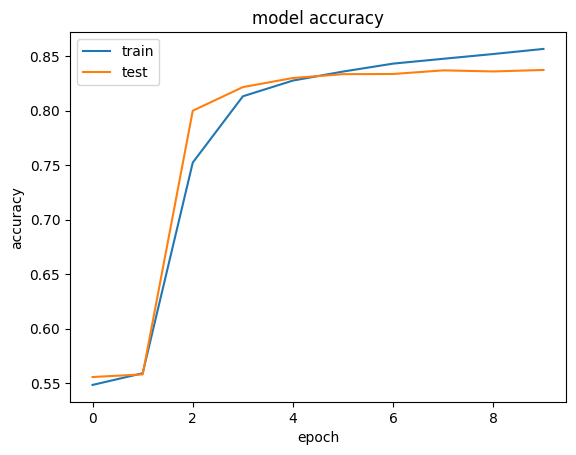

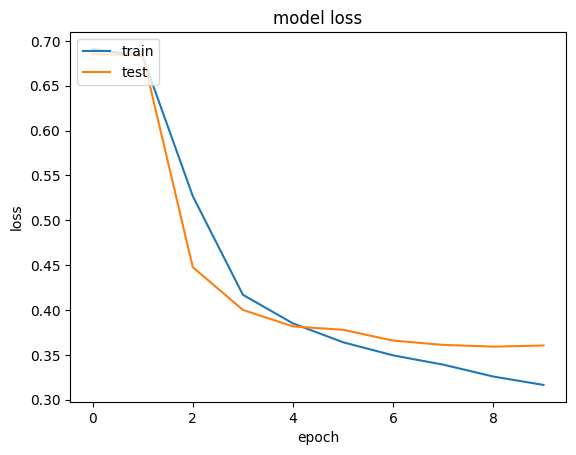

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
resolution_value = 1920
plt.savefig("images/lstm_single_accuracy_vs_epoch.png", format="png", dpi=resolution_value)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig("images/lstm_single_loss_vs_epoch.png", format="png", dpi=resolution_value)
plt.show()

# Multi-lable Text Classification Model with Multiple Output Layers

In [20]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sen))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [21]:
X = []
sentences = list(df["cleaned"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = df[["hate_speech", "cyberbullying"]]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
# First output
y1_train = y_train[["hate_speech"]].values
y1_test =  y_test[["hate_speech"]].values

# Second output
y2_train = y_train[["cyberbullying"]].values
y2_test =  y_test[["cyberbullying"]].values

In [24]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [25]:
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [27]:
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 100)     5222300     ['input_2[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          117248      ['embedding_1[0][0]']            
                                                                                                  
 dense_1 (Dense)                (None, 1)            129         ['lstm_1[0][0]']                 
                                                                                            

In [28]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True, dpi=1920)

In [29]:
history = model.fit(x=X_train, y=[y1_train, y2_train], batch_size=8192, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 75s 9s/step - loss: 1.3801 - dense_1_loss: 0.6903 - dense_2_loss: 0.6898 - dense_1_acc: 0.5340 - dense_2_acc: 0.5478 - val_loss: 1.3708 - val_dense_1_loss: 0.6861 - val_dense_2_loss: 0.6847 - val_dense_1_acc: 0.5492 - val_dense_2_acc: 0.5559
Epoch 2/10
8/8 [==============================] - 69s 9s/step - loss: 1.3713 - dense_1_loss: 0.6862 - dense_2_loss: 0.6851 - dense_1_acc: 0.5441 - dense_2_acc: 0.5499 - val_loss: 3.0325 - val_dense_1_loss: 1.5150 - val_dense_2_loss: 1.5175 - val_dense_1_acc: 0.4878 - val_dense_2_acc: 0.4825
Epoch 3/10
8/8 [==============================] - 68s 9s/step - loss: 1.5792 - dense_1_loss: 0.7901 - dense_2_loss: 0.7892 - dense_1_acc: 0.5371 - dense_2_acc: 0.5416 - val_loss: 1.3714 - val_dense_1_loss: 0.6864 - val_dense_2_loss: 0.6850 - val_dense_1_acc: 0.5488 - val_dense_2_acc: 0.5554
Epoch 4/10
8/8 [==============================] - 69s 9s/step - loss: 1.3728 - dense_1_loss: 0.6870 - dense_2_loss: 0.6858 -

In [30]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

636/636 [==============================] - 16s 25ms/step - loss: 1.3721 - dense_1_loss: 0.6865 - dense_2_loss: 0.6855 - dense_1_acc: 0.5457 - dense_2_acc: 0.5513
Test Score: 1.3720587491989136
Test Accuracy: 0.6865180134773254


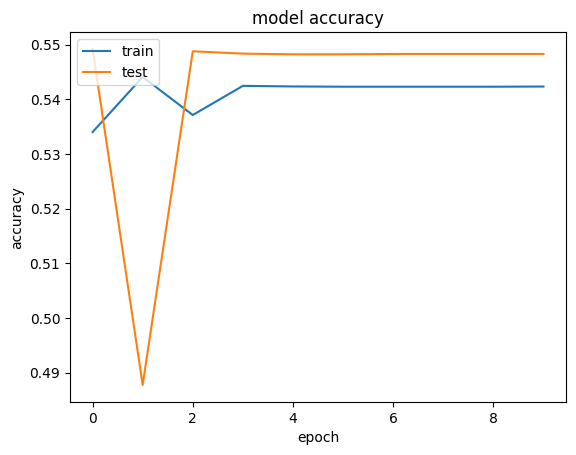

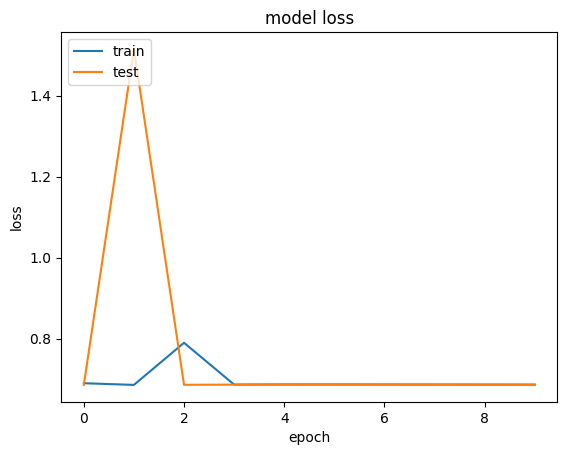

In [34]:
plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig("images/lstm_multi_accuracy_vs_epoch.png", format="png", dpi=resolution_value)
plt.show()

plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.savefig("images/lstm_multi_loss_vs_epoch.png", format="png", dpi=resolution_value)
plt.show()